In [1]:
#%pip install --upgrade transformers==4.30.1
# %pip install emoji

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import AdamW
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision.datasets import ImageFolder

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from PIL import Image
from collections import Counter
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import re
from sklearn.preprocessing import Normalizer
from nltk.corpus import stopwords
import nltk
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
from sklearn.base import BaseEstimator, TransformerMixin
from pymorphy3 import MorphAnalyzer
from torch.nn.utils.rnn import pad_sequence
from nltk.tokenize import word_tokenize
import emoji
from typing import List, Tuple, Dict
from transformers import AutoTokenizer

from transformers import AutoModelForSequenceClassification
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score

import torch.nn.functional as F

In [4]:
train = pd.read_csv('train.csv', encoding="UTF-8")
test = pd.read_csv('test.csv', encoding="UTF-8")

In [5]:
train

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


In [6]:
test

,id,text
0,29568,"ЭЙ, ВЛЮБЛЁННЫЕ\nСкидка 20% промокоду SYHOYZ\nн..."
1,29569,Пруды Москвы
2,29570,🤪\n🤪\n👏\n👏\n😄\n😄\n👏\n👏\n👨‍👩‍👦\nСемейка лёгкого...
3,29571,24 СЕНТЯБРЯ\nИсторический фестиваль «Башкирия ...
4,29572,19-20 августа\nДетский клуб в кафе «Отдых»\nТе...
...,...,...
7387,36955,Концерт «Stabat Mater»\n24 и 25 марта в 20:00\...
7388,36956,СПЕКТАКЛЬ «ОДНАЖДЫ…»\nСпектакль для 1 зрителя....
7389,36957,вт.-пт. 10:00-20:00 можно бесплатно полетать н...
7390,36958,"ТЕАТРАЛЬНЫЙ СЕЗОН ""НА ВОДАХ""\nс 1 по 9 апреля ..."


# Анализ данных

In [7]:
lbls = pd.DataFrame(train['labels'].unique())
lbls

,0
0,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...
3535,0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 0
3536,1 0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0
3537,1 1 0 0 0 0 0 1 0 1 1 1 1 0 1 1 1 1 1 0
3538,1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0


In [8]:
train['labels'] = train['labels'].apply(lambda x: np.array(list(map(int, x.split()))))

# Создаем отдельные колонки для каждого класса (label_0, label_1, ...)
label_cols = [f'label_{i}' for i in range(20)]
for i in range(20):
    train[f'label_{i}'] = train['labels'].apply(lambda x: x[i])
                                        
train

,id,text,labels,label_0,label_1,label_2,label_3,label_4,label_5,label_6,label_7,label_8,label_9,label_10,label_11,label_12,label_13,label_14,label_15,label_16,label_17,label_18,label_19
0,0,15 января\nДетская развлекательная программа\n...,"[1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...",1,0,0,0,1,0,0,0,1,0,0,0,1,1,1,1,1,0,0,1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, ...",0,0,0,1,0,0,0,0,1,0,0,0,1,1,0,1,1,0,0,1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,1,0,0,1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...","[1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, ...",1,1,0,0,0,0,0,1,1,0,0,1,1,1,1,0,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, ...",0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,1,1,0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...","[1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...",1,1,1,0,0,0,0,1,0,1,1,1,0,1,1,0,1,1,1,0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,"[1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, ...",1,1,0,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, ...",1,0,1,0,0,0,0,1,0,1,1,1,0,1,1,0,0,1,1,0


label_18    24300
label_17    23523
label_8     23344
label_12    23071
label_13    22997
label_7     22555
label_14    22296
label_16    21933
label_9     20497
label_1     18979
label_11    18510
label_4     17812
label_0     15582
label_15    14925
label_10    12811
label_19     5765
label_3      1776
label_2      1490
label_6       206
label_5        99
dtype: int64


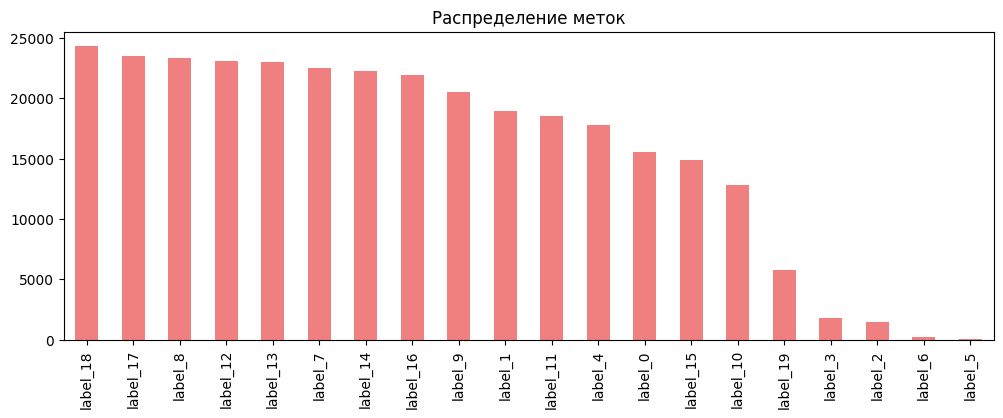

In [9]:
# посчитаем количество текстов для каждой метки и посмотрим их распределение
label_stats = train[label_cols].sum().sort_values(ascending=False)
print(label_stats)
label_stats.plot(kind='bar', color='lightcoral', figsize=(12, 4))
plt.title("Распределение меток")
plt.show()

In [10]:
train['num_labels'] = train[label_cols].sum(axis=1)
print("Среднее число меток на текст:", train['num_labels'].mean())

Среднее число меток на текст: 10.567877435064934


In [11]:
# посмотрим тексты с максимальным и минимальным количеством меток
train.sort_values('num_labels', ascending=False)[['text', 'num_labels']]

,text,num_labels
3122,Симфонический рок от Melodion Orchestra и песо...,16
29159,Поп-хиты со скидкой 15% в Колизее по промокоду...,16
17979,"Спектакль «Ты слишком много куришь, Лили»\n🏛\n...",16
29410,Сольный концерт Александра Малинина\n🏛\nЦДКЖ\n...,16
15468,🩷\nGuma\n🩷\nНастя Guma ворвалась в топы всех в...,16
...,...,...
5537,Новогодняя Табачка!\n🔴\nПодписаться на Новости...,4
19712,Елочка на площади Победы\n🔴\nПодписывайся на\n...,4
5529,Грибочки в Столешниковом переулке\n🍄\nФото: Иш...,4
12938,Розарий библиотеки им. В.И.Ленина\n🌹\nФото: Св...,4


count    29568.000000
mean       604.812331
std        380.114437
min          1.000000
25%        306.000000
50%        592.000000
75%        850.000000
max       4081.000000
Name: text_length, dtype: float64


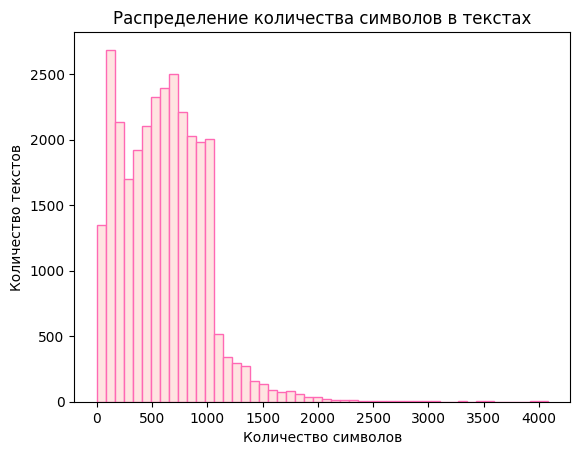

In [12]:
# посмотрим на длину текстов
train['text_length'] = train['text'].apply(len)
print(train['text_length'].describe())

plt.hist(train['text_length'], color='mistyrose', edgecolor='hotpink', bins=50)
plt.title('Распределение количества символов в текстах')
plt.xlabel('Количество символов')
plt.ylabel('Количество текстов')
plt.show()

In [13]:
train.sort_values('text_length')[['text', 'text_length', 'num_labels']]

,text,text_length,num_labels
12001,😂,1,5
284,Было?),6,5
26864,Кхм...,6,5
4395,Срочно,6,5
6032,А GSPD?,7,8
...,...,...,...
18344,ОТКРЫТИЕ ВЫСТАВКИ ТЕРАПЕВТИЧНЫХ ФОТОГРАФИЙ «ЭН...,3963,13
4481,НОВОЕ ШОУ ЗАСЛУЖЕННОГО АРТИСТА РОССИИ ГИИ ЭРАД...,3999,12
4664,И вот как-то при мне она унизила другую девочк...,4035,10
6097,"- Ты еще родишь много детей, - говорит он. – Я...",4036,10


In [14]:
print("Примеры для метки 18:")
print(train[train['label_18'] == 1]['text'].head(2).values)

print("Примеры для метки 5:")
print(train[train['label_5'] == 1]['text'].head(2).values)

Примеры для метки 18:
['Впервые в Уфе танцевальная терапия в группе с практикующим психологом\nТема встречи: «Отношения. Доверие. Контакт»\nПриходите, если:\n🔸\nвы хотите наладить или поисследовать свои отношения с\n-\xa0 телом\n- собой\n- близким человеком\n- работой\n- деньгами\n🔸\nне можете разрешить или забыть какую-то\xa0 ситуацию, связанную с отношениями\n🔸\nне умеете доверять или делегировать\n🔸\nтяжело вступаете в контакт\nЗадать вопрос психологу курса\nи записаться можно здесь:\n@LeontevaKsenia\nДата\n: 26 января\nВремя\n: 19.00-21.00\nАдрес\n: Коммунистическая, 45/3, Б/ц "Деловой двор"\nСтоимость: 1500\nЧто нужно для занятия:\nудобная одежда, носки, вода, желание танцевать.'
 '🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня открытие IV Международного конкурса GRAND PIANO (для пианистов до 16 лет) в зале Чайковского.\nСегодня прозвучит премьера концерта АЛЕКСАНДРА ЧАЙКОВСКОГО для 4 (!!!!) роялей!!!\nВместе с ДЕНИСОМ МАЦУЕВЫМ (которому и посвящён этот концерт)\nбудут играть лаур

In [15]:
# выведем самые частые слова
words = ' '.join(train['text']).lower().split()
word_counts = Counter(words)
print(word_counts.most_common(50))

[('в', 79739), ('и', 79433), ('на', 41725), ('по', 32283), ('с', 23839), ('-', 23131), ('билеты', 17598), ('для', 11990), ('от', 11433), ('не', 11422), ('—', 10300), ('📍', 10030), ('🗓', 9645), ('промокоду', 9463), ('со', 9434), ('до', 8361), ('из', 8304), ('это', 7634), ('а', 7477), ('🎫', 7400), ('ссылке', 7026), ('19:00', 6993), ('о', 6962), ('–', 6911), ('что', 6873), ('как', 6868), ('🏛', 6635), ('спектакль', 6386), ('здесь', 5472), ('💚', 5428), ('скидками', 5423), ('🥰', 5191), ('концерт', 4847), ('вас', 4770), ('за', 4716), ('к', 4704), ('|', 4518), ('все', 4396), ('вы', 4366), ('г.', 4349), ('✅', 4273), ('но', 4233), ('начало', 4048), ('театр', 4042), ('скидка', 4002), ('ул.', 3928), ('будет', 3896), ('🔥', 3844), ('20:00', 3841), ('у', 3671)]


In [16]:
print("Тексты без меток:", (train['num_labels'] == 0).sum())

Тексты без меток: 0


In [17]:
label_combinations = Counter(' '.join(map(str, x)) for x in train['labels'])
print("Топ-5 комбинаций меток:", label_combinations.most_common(5))

Топ-5 комбинаций меток: [('1 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0', 1053), ('1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0', 742), ('0 1 0 0 1 0 0 1 1 1 1 1 1 0 1 0 0 1 1 0', 727), ('1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0', 510), ('0 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0', 477)]


<Axes: >

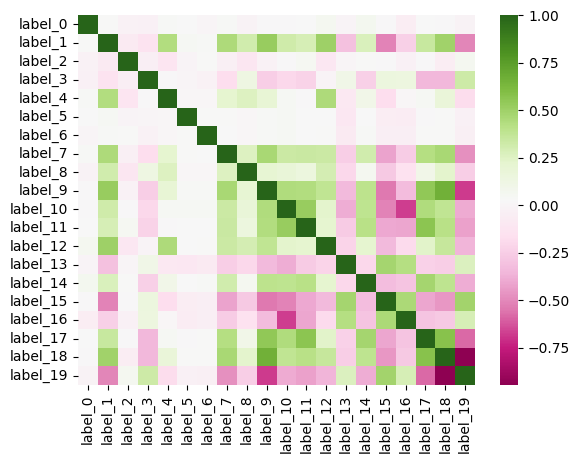

In [18]:
sns.heatmap(train[label_cols].corr(), cmap='PiYG')

## Итак, выводы по анализу данных
 Тексты похожи на анонсы мероприятий и спамные рекламные сообщения, размеченные метками, обозначающими вероятно какую-то информацию о самом мероприятии и содержании текста. Каждый текст содержит от 4 до 16 меток, а в среднем на каждый текст приходится 10-11 меток, так что вероятно метки достаточно информативны в совокупности. Распределены они тем не менее очень и очень плохо, огромный дисбаланс наблюдается (от 99 до 24300 ну что это такое😭). Также есть метки с высокой корреляцией, но мы не можем ничего удалять и объединять, к сожалению. Это приведет к потере данных.

Тексты разные: от коротких "😂" до огромных описаний на 4к символов, но большинство где-то 500-600 знаков. Из интересного - много смайликов используется, их надо попробовать как-то перекодировать тоже.

Основные проблемы датасета: дисбаланс, разнородность текстов по длине и содержанию, наличие спец символов и шумы типа `\n` и ссылок. По поводу последнего пункта, это мы решим токенизацией, удалим все общие символы, не несущие специальной информации (типа предлоги, запятые, переносы строк), главное не переборщить и не сломать структуру меток. Остальное как обычно решим взвешенным лоссом и подбором параметров.

# Пайплайны и модели очистки текста для 5 видов токенизации

In [40]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
labels = torch.from_numpy(np.array(train['labels'].tolist())).float()
texts = train['text'].tolist()

In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

In [21]:
def predict_for_csv(model, test_loader, device, threshold=0.3):
    model.eval()
    all_preds = []
    all_ids = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Predicting", leave=False):
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            ids = batch['id']  # должен быть в датасете

            logits = model(**inputs).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > threshold).astype(int)

            all_preds.extend(preds)
            all_ids.extend(ids)

    return all_ids, all_preds

In [22]:
import pandas as pd

def save_predictions_to_csv(ids, preds, output_path):
    df = pd.DataFrame({
        'id': [int(i) if isinstance(i, torch.Tensor) else i for i in ids],
        'labels': [' '.join(map(str, row)) for row in preds]
    })
    df.to_csv(output_path, index=False)

## 1. TF-IDF
TF-IDF определяет "важность" слов по количеству использования их в текстах, группируя схожие тексты. Для очистки текста надо заменить переносы строк на пробелы; ссылки, номера телефонов, хештеги на теги; заменить эмоджи на слова; привести все к нижнему регистру, также я бы удалила стоп-слова. Может стать проблемой разница в длине текстов, из-за чего я добавила бы нормализацию матрицы TF-IDF по длине текста. Для хотя бы минимального учета семантических отношений между словами можно также добавить N-граммы.

#### Вариант c очисткой от стоп-слов

In [45]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
russian_stopwords = stopwords.words('russian')
# функция очистки tf-idf
def clean_text_tfidf(text):
    text = text.replace('\n', ' ')
    text = emoji.demojize(text, delimiters=(" ", " ")) 
    text = re.sub(r'http\S+|www\.\S+', '[URL]', text)
    text = re.sub(r'@\S+', '[USER]', text)
    text = re.sub(r'#\S+', '[HASHTAG]', text)
    text = re.sub(r'\b\d{1,2}[:.]\d{2}\b', '[TIME]', text)
    text = re.sub(r'\b\d+[ррbр]\b', '[PRICE]', text)
    text = re.sub(r'\+7\s?\(?\d{3}\)?[\s-]?\d{3}[\s-]?\d{2}[\s-]?\d{2}', '[PHONE]', text)
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s.,!?;:\-\[\]]', ' ', text)
    text = text.lower()
    return ' '.join(text.split())

# класс для избирательной фильтрации
class ContextAwareTfidf(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super().build_analyzer()
        return lambda doc: [
            gram for gram in analyzer(doc)
            if (len(gram) > 2 and gram not in russian_stopwords)
            or gram.startswith(('[URL]', '[USER]', '[HASHTAG]', '[TIME]', '[PRICE]'))
        ]

# пайплайн с tf-idf
class TqdmPipeline(Pipeline):
    def fit(self, X, y):
        Xt = X
        with tqdm(total=len(self.steps), desc='Обучение модели') as pbar:
            for name, step in self.steps[:-1]:
                if hasattr(step, 'fit_transform'):
                    Xt = step.fit_transform(Xt, y)
                elif hasattr(step, 'fit'):
                    step.fit(Xt, y)
                    Xt = step.transform(Xt)
                pbar.update(1)
            self.steps[-1][1].fit(Xt, y)
            pbar.update(1)
        return self

In [49]:
tfidf_model = TqdmPipeline([
    ('tfidf', ContextAwareTfidf(
        preprocessor=clean_text_tfidf,
        ngram_range=(1, 3),
        max_features=20000,
        sublinear_tf=True,
        min_df=5, 
        max_df=0.95
    )),
    ('normalizer', Normalizer(norm='l2')),
    ('clf', MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=200,
            class_weight='balanced',
            max_depth=15,
            n_jobs=-1
        ), 
        n_jobs=-1
    ))
])

print("Запуск обучения...")
tfidf_model.fit(train_texts, train_labels)

def evaluate_with_progress(model, texts, val_labels):
    print("\nОценка модели...")
    labels_pred = []
    batches = np.array_split(texts, 10) 
    
    for batch in tqdm(batches, desc='Предсказание'):
        labels_pred.extend(model.predict(batch))
    
    print("\nОтчет по классификации:")
    print(classification_report(val_labels, labels_pred))
    
def predict_with_progress(model, texts):
    print("\nОценка модели...")
    labels_pred = []
    batches = np.array_split(texts, 10) 
    
    for batch in tqdm(batches, desc='Предсказание'):
        labels_pred.extend(model.predict(batch))
    return labels_pred

evaluate_with_progress(tfidf_model, val_texts, val_labels)

Запуск обучения...


Обучение модели: 100%|██████████| 3/3 [01:02<00:00, 21.00s/it]



Оценка модели...


Предсказание: 100%|██████████| 10/10 [00:16<00:00,  1.64s/it]


Отчет по классификации:
              precision    recall  f1-score   support

           0       0.71      0.84      0.77      3127
           1       0.93      0.71      0.81      3801
           2       0.25      0.72      0.37       299
           3       0.32      0.87      0.47       366
           4       0.90      0.71      0.80      3556
           5       0.75      0.15      0.25        20
           6       1.00      0.30      0.46        40
           7       0.97      0.68      0.80      4503
           8       0.99      0.78      0.87      4678
           9       0.95      0.79      0.86      4118
          10       0.83      0.80      0.81      2570
          11       0.93      0.78      0.85      3708
          12       0.96      0.82      0.88      4627
          13       0.93      0.92      0.92      4634
          14       0.95      0.76      0.85      4480
          15       0.81      0.90      0.85      3007
          16       0.92      0.87      0.89      4344
  

In [50]:
y_pred_tfidf = predict_with_progress(tfidf_model, test["text"].tolist())
y_pred_tfidf = np.array(y_pred_tfidf).astype(int)


Оценка модели...


Предсказание: 100%|██████████| 10/10 [00:18<00:00,  1.82s/it]


In [51]:
save_predictions_to_csv(test["id"], y_pred_tfidf, 'tfidf_submission.csv')

train['text'][22]

clean_text_tfidf(train['text'][22])

train['text'] = train['text'].apply(lambda x: clean_text_tfidf(x))

train['text_length2'] = train['text'].apply(len) # посмотрим на длину текстов теперь
print(train['text_length2'].describe())

plt.hist(train['text_length2'], color='mistyrose', edgecolor='hotpink', bins=50)
plt.title('Новое распределение количества символов в текстах')
plt.xlabel('Количество символов')
plt.ylabel('Количество текстов')
plt.show()

## 2. Word2Vec (эта модель выбила в кагле скор на прайвате)
Word2Vec способен выявлять контекст, синонимы и ассоциации, что хорошо подходит для нашей задачи. Для очистки текста сделаем такую же базовую предобработку (переносы строк, замена эмоджи, ссылок, телефонов, хештегов, нижний регистр). Также для уменьшения шума сделаем частичное удаление стоп-слов, не несущих контекстной информации, через лемматизацию с фильтрацией

In [35]:
nltk.download('punkt')
nltk.download('punkt_tab')
morph = MorphAnalyzer()

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [40]:
# частичное удаление стоп-слов
MINIMAL_STOPWORDS = {'и', 'в', 'с', 'у', 'к', 'на', 'за', 'по', 'из', 'от', 'о', 'но', 'а', 'же'}

# слова, которые нельзя удалять (для сохранения контекста)
KEEP_WORDS = {'не', 'ни', 'без', 'нет', 'для', 'до', 'после'}

# функция очистки Word2Vec
def clean_text_w2v(text):
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'http\S+|www\.\S+', '[URL]', text)
    text = re.sub(r'@\S+', '[USERNAME]', text)
    text = re.sub(r'#\S+', '[HASHTAG]', text)
    text = re.sub(r'\+7\s?\(?\d{3}\)?[\s-]?\d{3}[\s-]?\d{2}[\s-]?\d{2}', '[PHONE_NUMBER]', text)
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s\-.,!?;:]', ' ', text)
    text = text.lower()
    return ' '.join(text.split())

# лемматизация с частичной фильтрацией
def lemmatize_with_filter(text):
    tokens = word_tokenize(text)
    lemmas = []
    for token in tokens:
        if len(token) <= 2 and token not in KEEP_WORDS:
            continue
            
        lemma = morph.parse(token)[0].normal_form
        if lemma not in MINIMAL_STOPWORDS or lemma in KEEP_WORDS:
            lemmas.append(lemma)
            
    return lemmas

# трансформер
class Word2VecTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vector_size=300, window=5, min_count=3):
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.model = None
        
    def fit(self, X, y=None):
        sentences = [lemmatize_with_filter(clean_text_w2v(text)) for text in X]
        self.model = Word2Vec(
            sentences=sentences,
            vector_size=self.vector_size,
            window=self.window,
            min_count=self.min_count,
            sg=1,
            hs=0,
            negative=5,
            workers=4
        )
        return self
        
    def transform(self, X):
        def text_to_vector(text):
            words = lemmatize_with_filter(clean_text_w2v(text))
            vectors = [self.model.wv[word] for word in words if word in self.model.wv]
            return np.mean(vectors, axis=0) if vectors else np.zeros(self.vector_size)
            
        return np.array([text_to_vector(text) for text in X])

# пайплайн Word2Vec
w2v_model = TqdmPipeline([
    ('w2v', Word2VecTransformer(vector_size=300)),
    ('normalizer', Normalizer(norm='l2')),
    ('clf', MultiOutputClassifier(RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)))
])

In [41]:
print("Запуск обучения...")
w2v_model.fit(train_texts, train_labels)

# 6. Оценка с tqdm
def evaluate_with_progress(model, texts, val_labels):
    print("\nОценка модели...")
    labels_pred = []
    batches = np.array_split(texts, 10)  # Разбиваем на 10 батчей
    
    for batch in tqdm(batches, desc='Предсказание'):
        labels_pred.extend(model.predict(batch))
    
    print("\nОтчет по классификации:")
    print(classification_report(val_labels, labels_pred))
    
def predict_with_progress(model, texts):
    print("\nОценка модели...")
    labels_pred = []
    batches = np.array_split(texts, 10)  # Разбиваем на 10 батчей
    
    for batch in tqdm(batches, desc='Предсказание'):
        labels_pred.extend(model.predict(batch))
    return labels_pred

evaluate_with_progress(w2v_model, val_texts, val_labels)

Запуск обучения...


Обучение модели: 100%|██████████| 3/3 [12:42<00:00, 254.22s/it]



Оценка модели...


Предсказание: 100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


Отчет по классификации:
              precision    recall  f1-score   support

           0       0.76      0.79      0.77      3127
           1       0.87      0.94      0.90      3801
           2       0.94      0.26      0.40       299
           3       0.91      0.64      0.75       366
           4       0.86      0.93      0.90      3556
           5       1.00      0.10      0.18        20
           6       1.00      0.28      0.43        40
           7       0.89      0.95      0.92      4503
           8       0.93      0.97      0.95      4678
           9       0.92      0.97      0.94      4118
          10       0.90      0.88      0.89      2570
          11       0.90      0.94      0.92      3708
          12       0.90      0.98      0.94      4627
          13       0.90      0.98      0.94      4634
          14       0.90      0.97      0.93      4480
          15       0.89      0.87      0.88      3007
          16       0.92      0.97      0.94      4344
  

In [42]:
y_pred_w2v = predict_with_progress(w2v_model, test["text"].tolist())


Оценка модели...


Предсказание: 100%|██████████| 10/10 [01:17<00:00,  7.79s/it]


In [51]:
y_pred_w2v = np.array(y_pred_w2v).astype(int)

In [52]:
save_predictions_to_csv(test["id"], y_pred_w2v, 'submission_w2v.csv')

## 3. Эмбеддинг для CNN

In [23]:
morph = MorphAnalyzer()

In [24]:
# предобработка текста
russian_stopwords = stopwords.words('russian')
def clean_text_cnn(text):
    text = re.sub(r'http\S+|www\.\S+', '[URL]', text)
    text = re.sub(r'@\S+', '[USER]', text)
    text = re.sub(r'#\S+', '[HASHTAG]', text)
    text = re.sub(r'(\+7|8)\s?\(?\d{3}\)?[\s-]?\d{3}[\s-]?\d{2}[\s-]?\d{2}\b', '[PHONE]', text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s\-\.,!?;:\[\]]', ' ', text)
    text = text.lower()
    words = text.split()
    cleaned_words = []
    for word in words:
        if word not in russian_stopwords and len(word) > 2:
            parsed = morph.parse(word)[0]
            lemma = parsed.normal_form
            cleaned_words.append(lemma)
    
    return ' '.join(cleaned_words)

In [25]:
class TextProcessor:
    def __init__(self, max_length: int = 100):
        self.word2idx: Dict[str, int] = {}  
        self.idx2word: Dict[int, str] = {} 
        self.max_length = max_length
        self.special_tokens = ['<pad>', '<unk>']
        self._init_special_tokens()
    
    def _init_special_tokens(self):
        for i, token in enumerate(self.special_tokens):
            self.word2idx[token] = i
            self.idx2word[i] = token
    
    def build_vocab(self, texts: List[str], min_freq: int = 2):
        word_counts = Counter()
        for text in texts:
            lemmas = clean_text_cnn(text)
            word_counts.update(lemmas)
        filtered_words = [word for word, count in word_counts.items() 
                         if count >= min_freq and word not in self.word2idx]

        for idx, word in enumerate(filtered_words, start=len(self.special_tokens)):
            self.word2idx[word] = idx
            self.idx2word[idx] = word
        

        self.vocab_size = len(self.word2idx)
    
    def text_to_sequence(self, text: str) -> torch.Tensor:
        lemmas = clean_text_cnn(text)
        
        sequence = [
            self.word2idx.get(lemma, self.word2idx['<unk>'])
            for lemma in lemmas[:self.max_length]
        ]
        
        return torch.tensor(sequence, dtype=torch.long)
    
    def collate_fn(self, batch: List[Tuple[str, torch.Tensor]]) -> Tuple[torch.Tensor, torch.Tensor]:
        texts, labels = zip(*batch)
        
        sequences = [self.text_to_sequence(text) for text in texts]
       
        padded_sequences = pad_sequence(
            sequences,
            batch_first=True,
            padding_value=self.word2idx['<pad>']
        )

        labels_tensor = torch.stack(labels)
        
        return padded_sequences, labels_tensor
    
    def __len__(self) -> int:
        return len(self.word2idx)

In [61]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, num_classes: int, pad_idx: int):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)

        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=4, padding=2)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=128, kernel_size=5, padding=2)

        self.dropout = nn.Dropout(0.5)
        self.pool = nn.AdaptiveMaxPool1d(1)  # фиксируем размерность
        self.fc = nn.Linear(128 * 3, num_classes)  # 3 conv слоя × 128 каналов = 384

    def forward(self, x):
        x = self.embedding(x)               # (B, L, E)
        x = x.permute(0, 2, 1)              # (B, E, L)

        x1 = F.relu(self.conv1(x))          # (B, C, L)
        x2 = F.relu(self.conv2(x))
        x3 = F.relu(self.conv3(x))

        x1 = self.pool(x1).squeeze(-1)      # (B, C)
        x2 = self.pool(x2).squeeze(-1)
        x3 = self.pool(x3).squeeze(-1)

        x = torch.cat([x1, x2, x3], dim=1)  # (B, 3C)
        x = self.dropout(x)
        x = self.fc(x)                      # (B, num_classes)

        return x


In [37]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer

class TextDataset(Dataset):
    def __init__(self, texts, labels, processor, mlb):
        self.texts = [clean_text_cnn(t) for t in texts]
        self.labels = torch.FloatTensor(labels)
        self.processor = processor

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

In [35]:
processor = TextProcessor(max_length=100)
processor.build_vocab(train_texts)

mlb = MultiLabelBinarizer()
mlb.fit(train_labels)

MultiLabelBinarizer()

In [38]:
train_dataset = TextDataset(train_texts, train_labels, processor, mlb)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=processor.collate_fn)

In [62]:
model_cnn = TextCNN(vocab_size=len(processor), 
                    embedding_dim=100, 
                    num_classes=len(mlb.classes_), 
                    pad_idx=processor.word2idx['<pad>']).to(device)
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

In [64]:
# for epoch in range(10):
#     model_cnn.train()
#     total_loss = 0
#     for inputs, targets in train_loader:
#         inputs, targets = inputs.to(device), targets.to(device)
#         optimizer.zero_grad()
#         outputs = model_cnn(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

## 4. Эмбеддинг для RNN

In [65]:
def clean_text_rnn(text: str) -> str:
    text = re.sub(r'http\S+|www\.\S+', '[URL]', text)
    text = re.sub(r'@\S+', '[USER]', text)
    text = re.sub(r'#\S+', '[HASHTAG]', text)
    text = re.sub(r'(\+7|8)\s?\(?\d{3}\)?[\s-]?\d{3}[\s-]?\d{2}[\s-]?\d{2}\b', '[PHONE]', text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'[^a-zA-Zа-яА-ЯёЁ0-9\s\-\.,!?;:’\'"\[\]]', ' ', text)
    text = text.lower()
    words = []
    for word in text.split():
        if word not in stopwords:  # Только стоп-слова
            parsed = morph.parse(word)[0]
            words.append(parsed.normal_form)
    
    return ' '.join(words)

labels = torch.from_numpy(np.array(train['labels'].tolist())).float()
texts = train['text'].tolist()

In [66]:
class TextProcessorRNN:
    def __init__(self, max_len=100):
        self.word2idx = {'<pad>': 0, '<unk>': 1}
        self.idx2word = {0: '<pad>', 1: '<unk>'}
        self.max_len = max_len
    
    def build_vocab(self, texts, min_freq=2):
        counter = Counter()
        for text in texts:
            cleaned = clean_text_rnn(text)
            words = cleaned.split()
            counter.update(words)
        
        for word, freq in counter.items():
            if freq >= min_freq and word not in self.word2idx:
                idx = len(self.word2idx)
                self.word2idx[word] = idx
                self.idx2word[idx] = word
    
    def text_to_sequence(self, text):
        cleaned = clean_text_rnn(text)  # Очистка перед преобразованием
        words = cleaned.split()[:self.max_len]
        return torch.tensor([
            self.word2idx.get(word, self.word2idx['<unk>']) for word in words
        ], dtype=torch.long)
    
    def collate_fn(self, batch):
        texts, labels = zip(*batch)
        sequences = [self.text_to_sequence(txt) for txt in texts]
        padded = pad_sequence(sequences, batch_first=True, padding_value=self.word2idx['<pad>'])
        return padded, torch.stack(labels)

## 5. Эмбеддинг и модель для BERT

In [ ]:
def clean_text_bert(text: str) -> str:
    text = re.sub(r'http\S+|www\.\S+', '[URL]', text)
    text = re.sub(r'@\S+', '[USER]', text)
    text = re.sub(r'#\S+', '[HASHTAG]', text)
    text = re.sub(r'(\+7|8)\s?\(?\d{3}\)?[\s-]?\d{3}[\s-]?\d{2}[\s-]?\d{2}\b', '[PHONE]', text)
    text = emoji.demojize(text, delimiters=(" ", " "))
    text = re.sub(r'[^\w\s.,!?;:\-\'"()\[\]%$]', ' ', text)
    return text.strip()

In [ ]:
class BertMultiLabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = [clean_text_bert(t) for t in texts]
        self.labels = torch.FloatTensor(labels)
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': self.labels[idx]
        }

def calculate_class_weights(labels):
    pos_counts = np.sum(labels, axis=0)
    neg_counts = len(labels) - pos_counts
    weights = neg_counts / (pos_counts + 1e-6)
    return torch.FloatTensor(weights)

def multi_label_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average='weighted', zero_division=0)

In [ ]:
class BertMultiLabelTestDataset(Dataset):
    def __init__(self, test, tokenizer, max_len=128, labels=None):
        self.texts = [clean_text_bert(t) for t in test["text"].tolist()]
        self.ids = test["id"].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.has_labels = labels is not None
        if self.has_labels:
            self.labels = torch.FloatTensor(labels)
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        item = {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'id': self.ids[idx]
        }
        if self.has_labels:
            item['labels'] = self.labels[idx]
        return item

In [ ]:
class_weights = calculate_class_weights(np.array(labels))

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels=len(labels[0]),
    problem_type="multi_label_classification"
).to(device)

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

In [ ]:
train_dataset = BertMultiLabelDataset(train_texts, train_labels, tokenizer)
val_dataset = BertMultiLabelDataset(val_texts, val_labels, tokenizer)
test_dataset = BertMultiLabelTestDataset(test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

optimizer = AdamW(model.parameters(), lr=2e-5)
loss_func = torch.nn.BCEWithLogitsLoss(pos_weight=class_weights.to(device))

In [ ]:
for epoch in range(10):
    model.train()
    epoch_loss = 0
    
    train_progress = tqdm(train_loader, 
                         desc=f'Epoch {epoch+1}/5', 
                         leave=False,
                         bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    
    for batch in train_progress:
        optimizer.zero_grad()
        inputs = {
            'input_ids': batch['input_ids'].to(device),
            'attention_mask': batch['attention_mask'].to(device)
        }
        labels_batch = batch['labels'].to(device)
        
        outputs = model(**inputs)
        loss = loss_func(outputs.logits, labels_batch)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        train_progress.set_postfix({'loss': f'{loss.item():.4f}'})
    
    print(f'Epoch {epoch+1} - Avg Loss: {epoch_loss/len(train_loader):.4f}')

def evaluate(model, test_loader, device):
    model.eval()
    all_preds = []
    all_true = []
    
    # прогресс-бар
    eval_progress = tqdm(test_loader, 
                        desc='Evaluating', 
                        leave=False,
                        bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    
    with torch.no_grad():
        for batch in eval_progress:
            inputs = {
                'input_ids': batch['input_ids'].to(device),
                'attention_mask': batch['attention_mask'].to(device)
            }
            labels = batch['labels'].cpu().numpy()
            
            logits = model(**inputs).logits
            probs = torch.sigmoid(logits).cpu().numpy()
            preds = (probs > 0.3).astype(int)
            
            all_preds.extend(preds)
            all_true.extend(labels)
    
    print("\n" + "="*50)
    print("Результаты на тестовой выборке:")
    print(classification_report(
        np.array(all_true),
        np.array(all_preds),
        target_names=[f'label_{i}' for i in range(20)],
        digits=4
    ))
    print("="*50 + "\n")

In [ ]:
print("\nНачинаем оценку модели...")
evaluate(model, val_loader, device)

In [ ]:
ids, y_pred_bert = predict_for_csv(model, test_loader, device)
save_predictions_to_csv(ids, y_pred_bert, 'bert_submission.csv')

# Повторное сохранение предикта, выбившего скор на кагле (на прайвате, на паблике был берт)

In [ ]:
save_predictions_to_csv(test["id"], y_pred_w2v, 'kaggle_finish.csv')